In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
# from google.colab import files
# uploaded = files.upload()

In [4]:
# !unzip -q /content/PJME_hourly.csv.zip

In [7]:
# !ls /content/
# print(uploaded.keys())

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [61]:
df = pd.read_csv('/content/PJME_hourly.csv')
df.head(3)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0


In [62]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

In [63]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [64]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


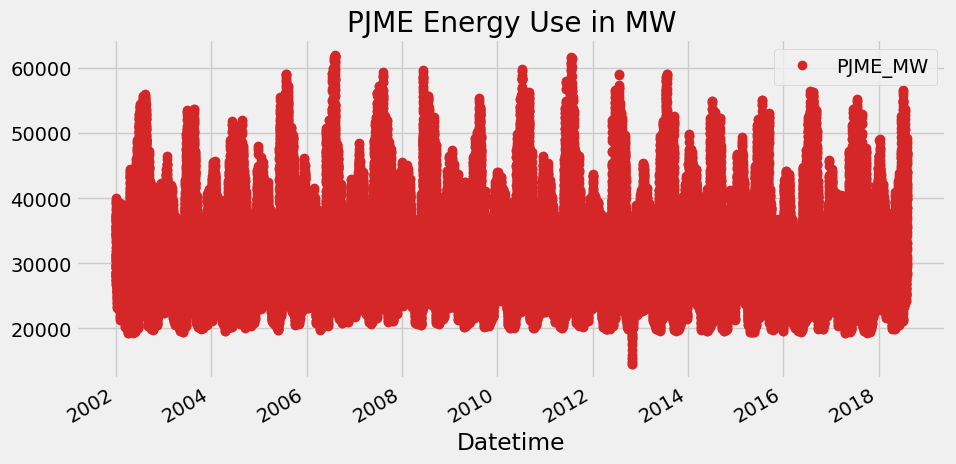

In [66]:
df.plot(style='o',
        figsize=(10, 5),
        color=color_pal[3],
        title='PJME Energy Use in MW')
plt.show()

# Outlier handlingOutlier Analysis and removal

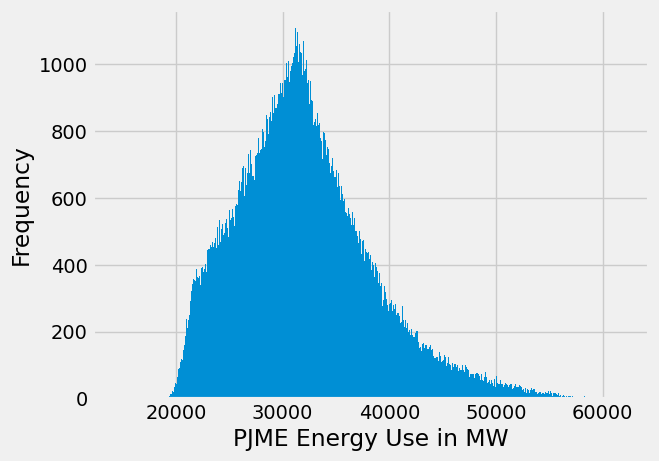

In [67]:
df['PJME_MW'].plot(kind='hist', bins=500)
plt.xlabel('PJME Energy Use in MW')
plt.show()

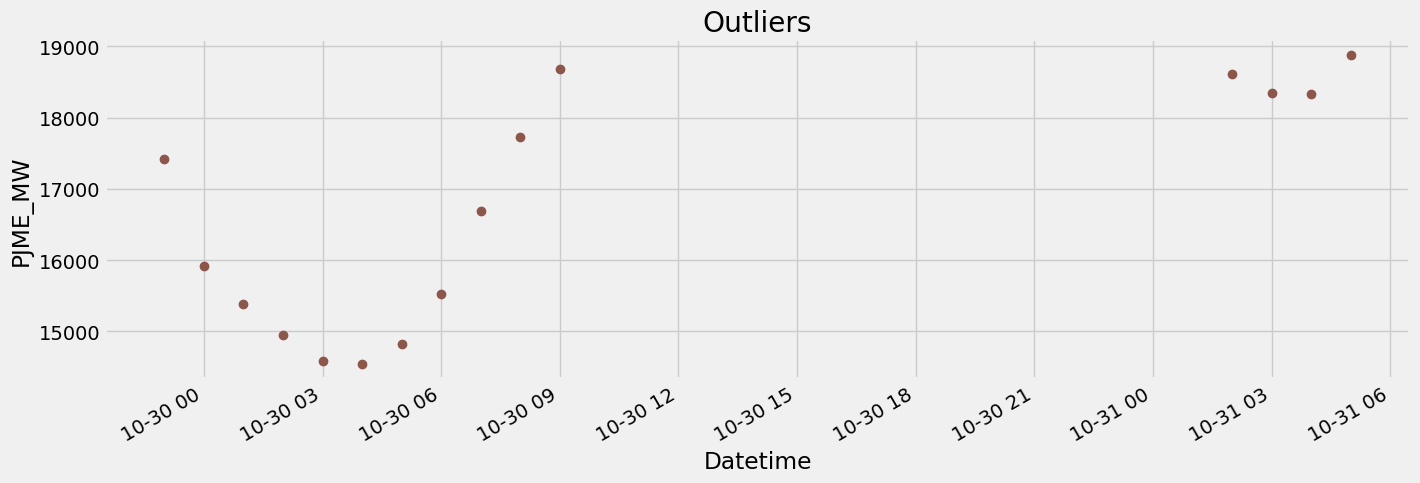

In [15]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='o',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.show()

In [68]:
df = df.query('PJME_MW > 19_000').copy()

# Train / Test Split

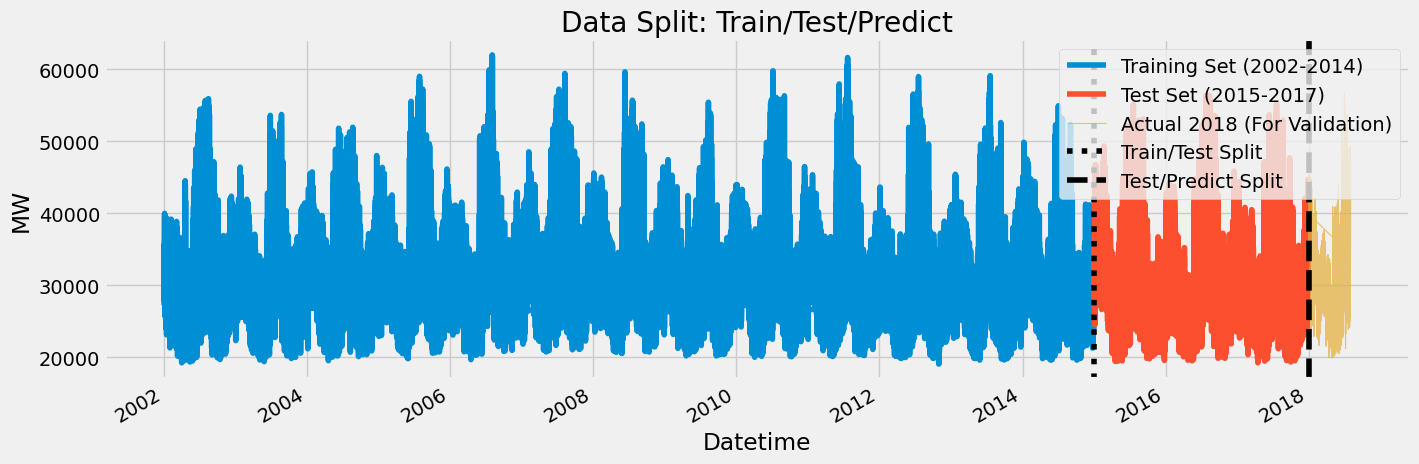

Training set: 113,911 hours (2002-01-01 to 2014-12-31)
Test set: 26,304 hours (2015-01-01 to 2017-12-31)
Validation period (2018): 5,136 hours (2018-01-01 to 2018-08-03)


In [69]:
# NEW SPLIT: Train (2002-2014), Test (2015-2017), Predict (2018)
train = df.loc[df.index < '01-01-2015']           # 2002-2014
test = df.loc[(df.index >= '01-01-2015') &
              (df.index < '01-01-2018')]          # 2015-2017
predict_period = df.loc['2018']                   # Actual 2018 values for comparison

fig, ax = plt.subplots(figsize=(15, 5))
train['PJME_MW'].plot(ax=ax, label='Training Set (2002-2014)', title='Data Split: Train/Test/Predict')
test['PJME_MW'].plot(ax=ax, label='Test Set (2015-2017)')
predict_period['PJME_MW'].plot(ax=ax, label='Actual 2018 (For Validation)', alpha=0.7, linewidth=0.8)

# Add vertical lines for clarity
ax.axvline('01-01-2015', color='black', ls=':', label='Train/Test Split')
ax.axvline('01-01-2018', color='black', ls='--', label='Test/Predict Split')

ax.set_ylabel('MW')
ax.legend()
plt.show()

# Print sizes
print(f"Training set: {train.shape[0]:,} hours ({train.index.min().date()} to {train.index.max().date()})")
print(f"Test set: {test.shape[0]:,} hours ({test.index.min().date()} to {test.index.max().date()})")
print(f"Validation period (2018): {predict_period.shape[0]:,} hours ({predict_period.index.min().date()} to {predict_period.index.max().date()})")

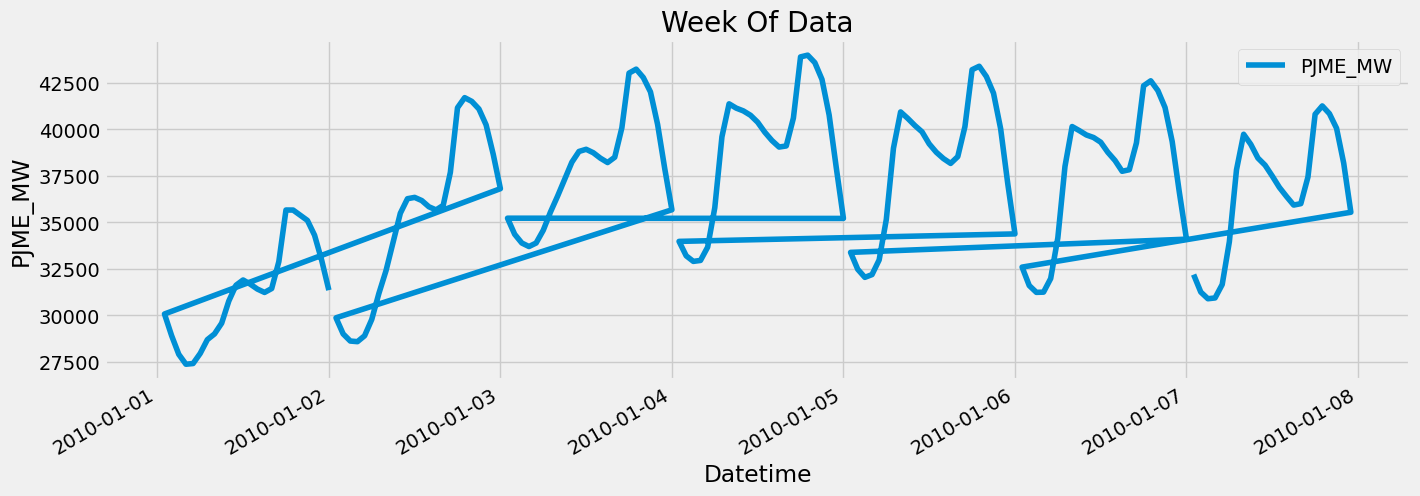

In [22]:
(df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data'))
plt.ylabel('PJME_MW')
plt.show()

# TimeSeries Cross Validation

Year: 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015

Fold 0:  [============ TRAIN ============][GAP][=== TEST 2011 ===]

Fold 1:  [================ TRAIN ===============][GAP][=== TEST 2012 ===]  
Fold 2:  [==================== TRAIN =================][GAP][=== TEST 2013 ===]

Fold 3:  [======================== TRAIN =====================][GAP][=== TEST 2014 ===]

Fold 4:  [============================ TRAIN =========================][GAP][=== TEST 2015 ===]

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
# df = df.sort_index()

A sliding window moving through time:

Fold 0: [Train: 2002-2010] | [Test: 2011]

Fold 1: [Train: 2002-2011] | [Test: 2012]

Fold 2: [Train: 2002-2012] | [Test: 2013]

Fold 3: [Train: 2002-2013] | [Test: 2014]

Fold 4: [Train: 2002-2014] | [Test: 2015]

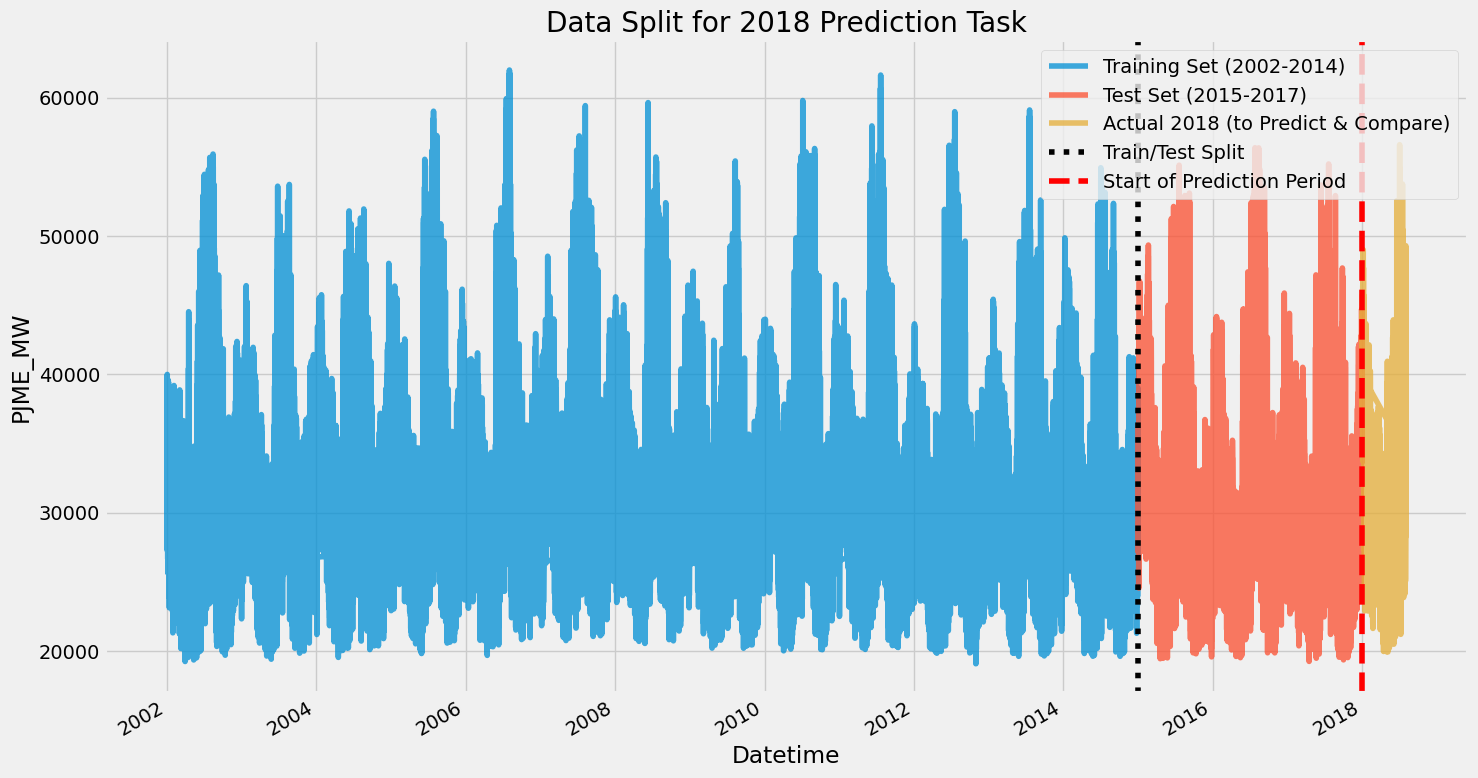

In [23]:
# Visualize the new Train (2002-2014), Test (2015-2017), Predict (2018) split
fig, ax = plt.subplots(figsize=(15, 8))

# Plot each period
train['PJME_MW'].plot(ax=ax, label='Training Set (2002-2014)', alpha=0.75)
test['PJME_MW'].plot(ax=ax, label='Test Set (2015-2017)', alpha=0.75)
predict_period['PJME_MW'].plot(ax=ax, label='Actual 2018 (to Predict & Compare)', alpha=0.75)

# Add vertical split lines
ax.axvline(pd.Timestamp('2015-01-01'), color='black', linestyle=':', label='Train/Test Split')
ax.axvline(pd.Timestamp('2018-01-01'), color='red', linestyle='--', label='Start of Prediction Period')

ax.set_ylabel('PJME_MW')
ax.set_title('Data Split for 2018 Prediction Task')
ax.legend()
plt.tight_layout()
plt.show()

# Feature Creation

In [24]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

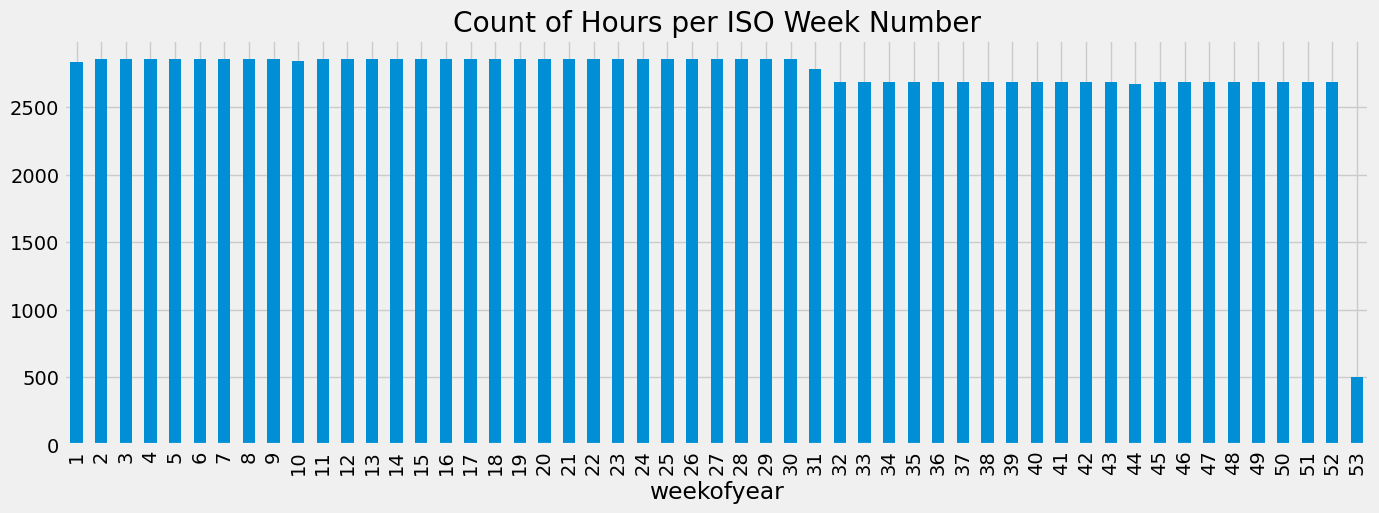

In [25]:
# See the week distribution
df['weekofyear'].value_counts().sort_index().plot(kind='bar', figsize=(15,5))
plt.title('Count of Hours per ISO Week Number')
plt.show()

In [26]:
df.sample(5)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2006-08-24 07:00:00,31665.0,7,3,3,8,2006,236,24,34
2002-05-15 19:00:00,29746.0,19,2,2,5,2002,135,15,20
2016-04-27 16:00:00,27858.0,16,2,2,4,2016,118,27,17
2018-03-20 14:00:00,36142.0,14,1,1,3,2018,79,20,12
2006-08-11 01:00:00,31577.0,1,4,3,8,2006,223,11,32


# Lag Features

lag1: Energy consumption from exactly 1 year ago (364 days)

lag2: Energy consumption from exactly 2 years ago (728 days = 364×2)

lag3: Energy consumption from exactly 3 years ago (1092 days = 364×3)

In [27]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [28]:
df = add_lags(df)

In [29]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,34600.0,41772.0,40740.0
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,33674.0,41393.0,40049.0
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,32035.0,40092.0,38473.0
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1,1,1,29870.0,37911.0,35962.0
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2,2,1,27771.0,35931.0,33680.0


# Visualize our Feature / Target Relationship

**Each box at hour 0, 1, 2...23 shows:**

. Median line: The "typical" consumption for that hour

. Box edges (25th-75th percentile): Where most values fall

. Whiskers: The "normal" range (excluding outliers)

. Dots: Extreme outlier hours

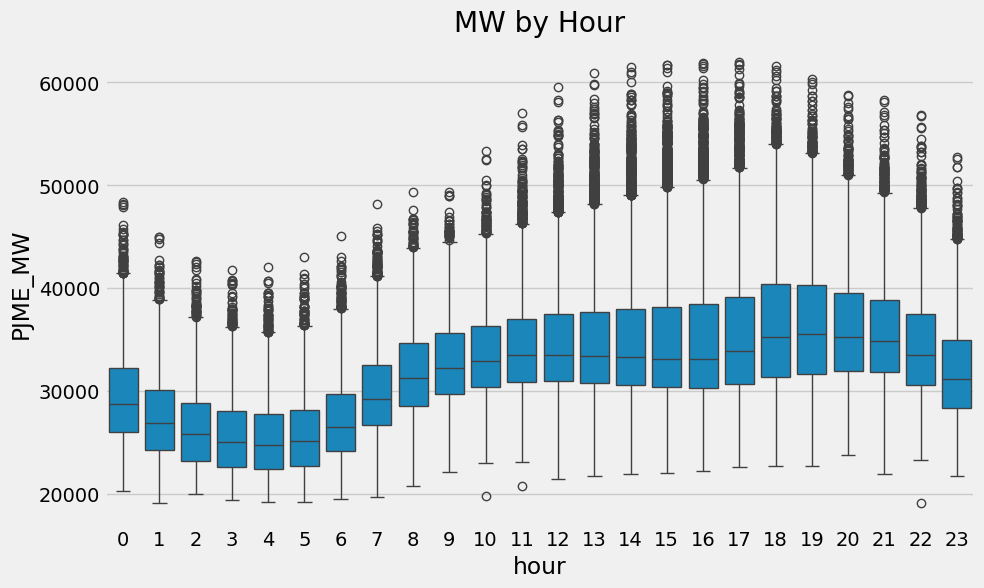

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

/tmp/ipython-input-1428223657.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Greens')


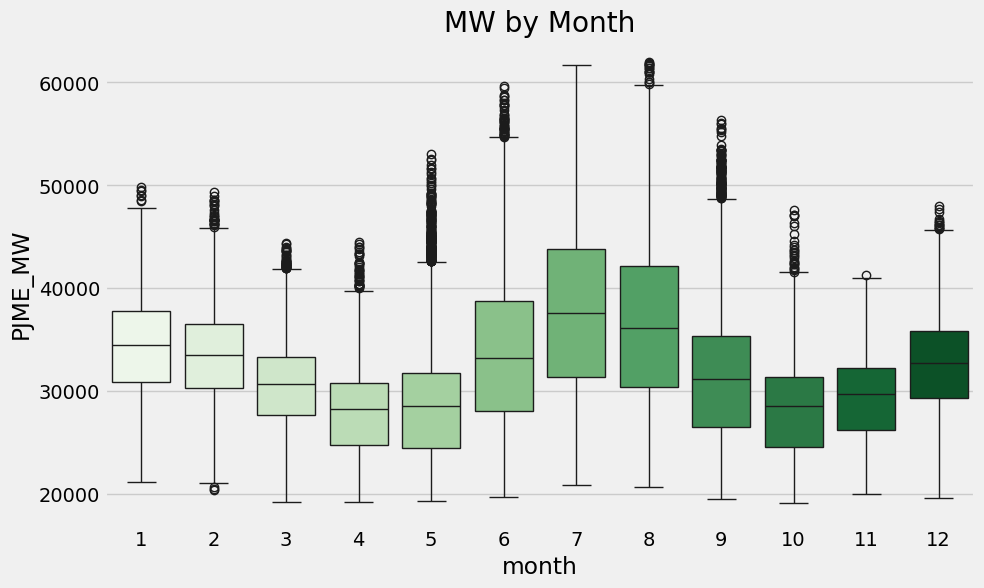

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Greens')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [34]:
# ===== APPLY FEATURE ENGINEERING TO SPLITS =====
# Create features on the full df first (you may have done this already)
df = create_features(df)
df = add_lags(df)

# Now recreate your splits WITH the new features
train = df.loc[df.index < '01-01-2015']           # 2002-2014
test = df.loc[(df.index >= '01-01-2015') &
              (df.index < '01-01-2018')]          # 2015-2017
predict_period = df.loc['2018']                   # Actual 2018 values

print("✅ Features created and splits updated.")
print(f"Train columns: {train.columns.tolist()}")

✅ Features created and splits updated.
Train columns: ['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'lag1', 'lag2', 'lag3']


In [35]:
# ===== TRAIN FINAL MODEL ON 2002-2014 =====
# Use the 'train' DataFrame we already created (2002-2014)
train_data = train.copy()
test_data = test.copy()  # 2015-2017, for optional quick check

# Ensure features exist (they should from running create_features on the full df)
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year','lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_train = train_data[FEATURES]
y_train = train_data[TARGET]

# Optional: Quick check on 2015-2017 test period
X_test_check = test_data[FEATURES]
y_test_check = test_data[TARGET]

# Create and train the model
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       max_depth=3,
                       learning_rate=0.01)

# Train with validation on the test set (2015-2017) to prevent overfitting
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test_check, y_test_check)],
        verbose=100)

# Optional: Print performance on the 2015-2017 test period
check_pred = reg.predict(X_test_check)
check_score = np.sqrt(mean_squared_error(y_test_check, check_pred))
print(f'\nModel RMSE on 2015-2017 test period: {check_score:.2f}')

print("\n✅ Model trained on 2002-2014. Ready to predict 2018.")

[0]	validation_0-rmse:6412.53311	validation_1-rmse:6526.20165
[100]	validation_0-rmse:4349.11089	validation_1-rmse:4508.68305
[200]	validation_0-rmse:3813.69510	validation_1-rmse:4090.45711
[300]	validation_0-rmse:3563.95273	validation_1-rmse:3969.65857
[400]	validation_0-rmse:3419.42001	validation_1-rmse:3929.94636
[500]	validation_0-rmse:3338.71277	validation_1-rmse:3922.32433
[528]	validation_0-rmse:3320.33355	validation_1-rmse:3922.43998

Model RMSE on 2015-2017 test period: 3920.50

✅ Model trained on 2002-2014. Ready to predict 2018.


In [38]:
# ===== MODEL PERFORMANCE SUMMARY =====
print('=' * 50)
print('MODEL PERFORMANCE SUMMARY')
print('=' * 50)
print(f'Training Period: {train.index.min().date()} to {train.index.max().date()}')  # FIXED: min to max
print(f'Validation Period (for early stopping): {test.index.min().date()} to {test.index.max().date()}')
print(f'RMSE on 2015-2017 validation period: {check_score:.2f} MW')
print(f'Model trained with {len(reg.feature_importances_)} features.')
print('\nNext: Use this model to predict 2018 and compare with actual values.')
print('=' * 50)

MODEL PERFORMANCE SUMMARY
Training Period: 2002-01-01 to 2014-12-31
Validation Period (for early stopping): 2015-01-01 to 2017-12-31
RMSE on 2015-2017 validation period: 3920.50 MW
Model trained with 9 features.

Next: Use this model to predict 2018 and compare with actual values.


# Predict the Future

In [39]:
# df = create_features(df)

# FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','lag1','lag2','lag3']
# TARGET = 'PJME_MW'

# X_all = df[FEATURES]
# y_all = df[TARGET]

# reg = xgb.XGBRegressor(base_score=0.5,
#                        booster='gbtree',
#                        n_estimators=500,
#                        objective='reg:linear',
#                        max_depth=3,
#                        learning_rate=0.01)
# reg.fit(X_all, y_all,
#         eval_set=[(X_all, y_all)],
#         verbose=100)

In [40]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [41]:
# ===== CREATE 2018 FUTURE DATES FOR PREDICTION =====
# Create hourly timestamps for ALL of 2018
future = pd.date_range('2018-01-01', '2018-12-31 23:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

# Ensure main df has the marker
df['isFuture'] = False

# Combine historical and future
df_and_future = pd.concat([df, future_df])

# Apply the SAME feature engineering
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

print(f"Created {len(future)} future timestamps for prediction: {future[0]} to {future[-1]}")
print(f"Total dataframe size: {len(df_and_future)} rows (historical + future)")

Created 8760 future timestamps for prediction: 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Total dataframe size: 154111 rows (historical + future)


In [42]:
future_df

,isFuture
2018-01-01 00:00:00,True
2018-01-01 01:00:00,True
2018-01-01 02:00:00,True
2018-01-01 03:00:00,True
2018-01-01 04:00:00,True
...,...
2018-12-31 19:00:00,True
2018-12-31 20:00:00,True
2018-12-31 21:00:00,True
2018-12-31 22:00:00,True


In [43]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
Datetime,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,30393.0,NaN,NaN,False
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,29265.0,NaN,NaN,False
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,28357.0,NaN,NaN,False
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,27899.0,NaN,NaN,False
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,28057.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,1,1,34600.0,41772.0,40740.0,False
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,1,1,33674.0,41393.0,40049.0,False
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,1,1,32035.0,40092.0,38473.0,False


In [44]:
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,30393.0,NaN,NaN,False
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,29265.0,NaN,NaN,False
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,28357.0,NaN,NaN,False
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,27899.0,NaN,NaN,False
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,28057.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,19,0,4,12,2018,365,31,1,NaN,35178.0,41830.0,True
2018-12-31 20:00:00,NaN,20,0,4,12,2018,365,31,1,NaN,34600.0,41772.0,True
2018-12-31 21:00:00,NaN,21,0,4,12,2018,365,31,1,NaN,33674.0,41393.0,True
2018-12-31 22:00:00,NaN,22,0,4,12,2018,365,31,1,NaN,32035.0,40092.0,True


In [54]:
future_w_features = df_and_future.query('isFuture').copy()

In [55]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-01-01 00:00:00,NaN,0,0,1,1,2018,1,1,1,27617.0,28152.0,26281.0,True
2018-01-01 01:00:00,NaN,1,0,1,1,2018,1,1,1,26216.0,26909.0,25134.0,True
2018-01-01 02:00:00,NaN,2,0,1,1,2018,1,1,1,25381.0,26369.0,24625.0,True
2018-01-01 03:00:00,NaN,3,0,1,1,2018,1,1,1,24962.0,26292.0,24556.0,True
2018-01-01 04:00:00,NaN,4,0,1,1,2018,1,1,1,24873.0,26573.0,24906.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,19,0,4,12,2018,365,31,1,NaN,35178.0,41830.0,True
2018-12-31 20:00:00,NaN,20,0,4,12,2018,365,31,1,NaN,34600.0,41772.0,True
2018-12-31 21:00:00,NaN,21,0,4,12,2018,365,31,1,NaN,33674.0,41393.0,True
2018-12-31 22:00:00,NaN,22,0,4,12,2018,365,31,1,NaN,32035.0,40092.0,True


In [56]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [57]:
future_w_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2018-01-01 00:00:00,NaN,0,0,1,1,2018,1,1,1,27617.0,28152.0,26281.0,True,29946.603516
2018-01-01 01:00:00,NaN,1,0,1,1,2018,1,1,1,26216.0,26909.0,25134.0,True,29022.210938
2018-01-01 02:00:00,NaN,2,0,1,1,2018,1,1,1,25381.0,26369.0,24625.0,True,28560.027344
2018-01-01 03:00:00,NaN,3,0,1,1,2018,1,1,1,24962.0,26292.0,24556.0,True,28120.644531
2018-01-01 04:00:00,NaN,4,0,1,1,2018,1,1,1,24873.0,26573.0,24906.0,True,28216.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,19,0,4,12,2018,365,31,1,NaN,35178.0,41830.0,True,34890.851562
2018-12-31 20:00:00,NaN,20,0,4,12,2018,365,31,1,NaN,34600.0,41772.0,True,34816.824219
2018-12-31 21:00:00,NaN,21,0,4,12,2018,365,31,1,NaN,33674.0,41393.0,True,34684.320312
2018-12-31 22:00:00,NaN,22,0,4,12,2018,365,31,1,NaN,32035.0,40092.0,True,33442.925781


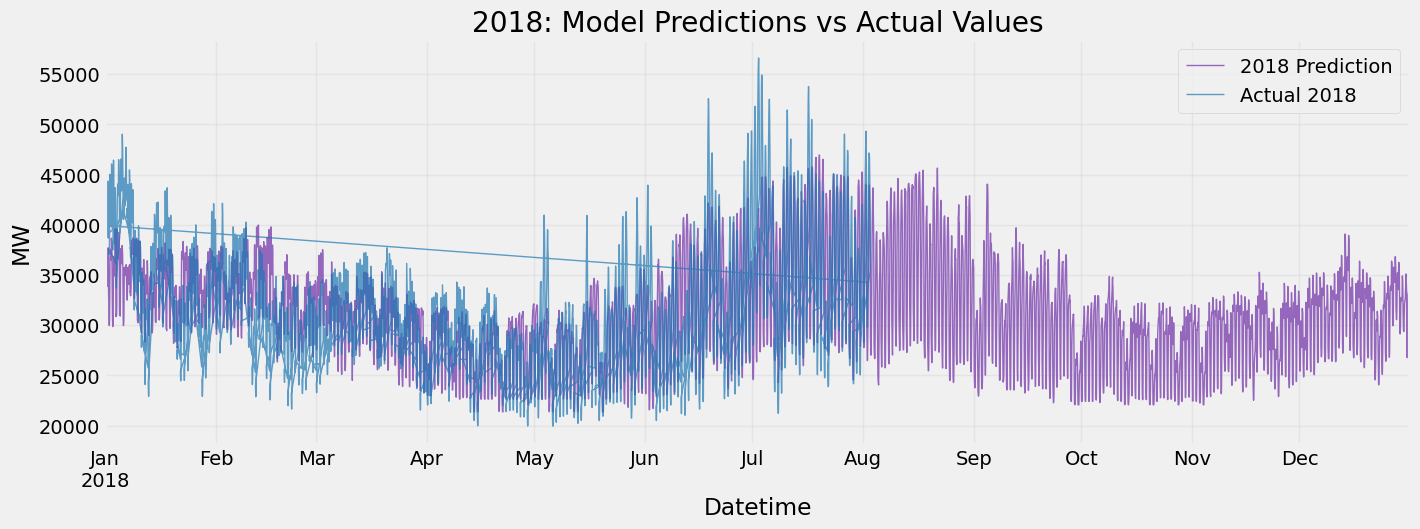

In [59]:
# OPTIONAL ENHANCEMENT: Plot predictions vs actuals together
fig, ax = plt.subplots(figsize=(15, 5))

# Plot predictions (what your model thinks will happen)
future_w_features['pred'].plot(ax=ax, color=color_pal[4],
                               linewidth=1, label='2018 Prediction')

# Plot actual values (what really happened)
if 'predict_period' in locals() or 'predict_period' in globals():
    actual_2018 = predict_period['PJME_MW']
    actual_2018.plot(ax=ax, color=color_pal[0],
                     linewidth=1, alpha=0.7, label='Actual 2018')

    ax.set_title('2018: Model Predictions vs Actual Values')
    ax.legend()
else:
    ax.set_title('2018 Predictions')

plt.ylabel('MW')
plt.grid(True, alpha=0.3)
plt.show()

In [60]:
# ===== FINAL 2018 PREDICTION EVALUATION =====
print('=' * 60)
print('FINAL MODEL PERFORMANCE ON 2018')
print('=' * 60)

# 1. Get your 2018 predictions and actuals
future_w_features = df_and_future.query('isFuture').copy()
predictions_2018 = future_w_features['pred']
actual_2018 = predict_period['PJME_MW']

# 2. Calculate final metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse_2018 = np.sqrt(mean_squared_error(actual_2018, predictions_2018))
mae_2018 = mean_absolute_error(actual_2018, predictions_2018)
mape_2018 = mean_absolute_percentage_error(actual_2018, predictions_2018) * 100

# 3. Display comprehensive results
print(f"📈 DATA RANGE:")
print(f"   PJME_MW range: {df['PJME_MW'].min():.0f} - {df['PJME_MW'].max():.0f} MW")
print(f"   Average consumption: {df['PJME_MW'].mean():.0f} MW")
print()

print(f"🎯 2018 FORECAST ACCURACY:")
print(f"   RMSE: {rmse_2018:.2f} MW")
print(f"   MAE:  {mae_2018:.2f} MW")
print(f"   MAPE: {mape_2018:.2f}% (Percentage Error)")
print()

print(f"📊 CONTEXT:")
print(f"   Model trained on: {train.index.min().date()} to {train.index.max().date()}")
print(f"   Forecast period: {actual_2018.index.min().date()} to {actual_2018.index.max().date()}")
print(f"   Total hours predicted: {len(predictions_2018):,}")
print()

print(f"✅ INTERPRETATION:")
if mape_2018 < 10:
    print(f"   Outstanding! <10% error for year-ahead hourly forecasts.")
elif mape_2018 < 15:
    print(f"   Good performance. {mape_2018:.1f}% error is operationally useful.")
else:
    print(f"   Room for improvement. {mape_2018:.1f}% error indicates challenging patterns.")

print('=' * 60)

# 4. Bonus: Peak error analysis
peak_error = (predictions_2018 - actual_2018).abs().max()
peak_error_time = (predictions_2018 - actual_2018).abs().idxmax()
print(f"\n⏰ Worst single hour prediction:")
print(f"   Time: {peak_error_time}")
print(f"   Actual: {actual_2018.loc[peak_error_time]:.0f} MW")
print(f"   Predicted: {predictions_2018.loc[peak_error_time]:.0f} MW")
print(f"   Error: {peak_error:.0f} MW")

FINAL MODEL PERFORMANCE ON 2018


KeyError: 'pred'